# Análise de Jira Sprints

O arquivo a ser processado é exportado através do filtro "Exportar issues_análise"no Jira LabCoMU

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [175]:
def prepare_df(df):
    df = df.iloc[:, [0, 1, 4, 5, 14, 15, 16, 17, 18, 20, 21, 25, 54, 58, 59, 60, 61]]

    # Rename selected columns
    df.columns = [
        'titulo', 'codigo', 'tipo', 'status', 'responsavel', 'solicitante', 
        'criador', 'data_criacao', 'data_atualizacao', 'data_resolucao', 
        'componente', 'descricao', 'story_points', 'sprint_1', 'sprint_2', 
        'sprint_3', 'sprint_4'
    ]
    
    # Fill empty date fields with a placeholder date before conversion
    df['data_criacao'].replace('', '01/01/70 00:00:00', inplace=True)
    df['data_atualizacao'].replace('', '01/01/70 00:00:00', inplace=True)
    df['data_resolucao'].replace('', '01/01/70 00:00:00', inplace=True)

    # Convert date columns to datetime
    df['data_criacao'] = pd.to_datetime(df['data_criacao'], format='%d/%m/%y %H:%M:%S').dt.date
    df['data_atualizacao'] = pd.to_datetime(df['data_atualizacao'], format='%d/%m/%y %H:%M:%S').dt.date
    df['data_resolucao'] = pd.to_datetime(df['data_resolucao'], format='%d/%m/%y %H:%M:%S').dt.date

    return df

def filter_sprint_ativa(df, sprint_ativa):
    return df[
        (df['sprint_1'] == sprint_ativa) |
        (df['sprint_2'] == sprint_ativa) |
        (df['sprint_3'] == sprint_ativa) |
        (df['sprint_4'] == sprint_ativa)
    ]

#### Especifique o arquivo e a Sprint a ser analisada abaixo

In [193]:
# Carregar o arquivo enviado
file_path = 'csv/jira-sprint3.csv'
sprint_ativa = 'Izy - Cycle 24.1 Sprint 3'

df_geral = pd.read_csv(file_path, sep=';', encoding='utf-8', on_bad_lines='skip')
df_geral = prepare_df(df_geral)
df = filter_sprint_ativa(df_geral, sprint_ativa)

/var/folders/m5/937z77hn3_jg_c963gpdx5fh0000gn/T/ipykernel_60035/1287096758.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['data_criacao'].replace('', '01/01/70 00:00:00', inplace=True)
/var/folders/m5/937z77hn3_jg_c963gpdx5fh0000gn/T/ipykernel_60035/1287096758.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_criacao'].re

#### Adicione abaixo as sprints mais recentes e suas datas pois o Jira não exporta

In [ ]:
sprint_dates = {
    'Izy - Cycle 24.1 Sprint 0': {'start': '07/11/24', 'end': '21/11/24'},
    'Izy - Cycle 24.1 Sprint 1': {'start': '19/11/24', 'end': '02/12/24'},
    'Izy - Cycle 24.1 Sprint 2': {'start': '03/12/24', 'end': '16/12/24'},
    'Izy - Cycle 24.1 Sprint 3': {'start': '16/12/24', 'end': '27/12/24'},
    'Izy - Cycle 24.1 Sprint 4': {'start': '07/01/25', 'end': '20/01/25'}
}

# Convert to DataFrame for easier manipulation
sprint_df = pd.DataFrame.from_dict(sprint_dates, orient='index')
sprint_df.index.name = 'sprint'
sprint_df['start'] = pd.to_datetime(sprint_df['start'], format='%d/%m/%y').dt.date
sprint_df['end'] = pd.to_datetime(sprint_df['end'], format='%d/%m/%y').dt.date
#sprint_df

In [186]:
feriados = {
    'Véspera de Natal': '24/12/24',
    'Natal': '25/12/24'
}

# Convert to DataFrame for easier manipulation
feriados_df = pd.DataFrame.from_dict(feriados, orient='index')
feriados_df.index.name = 'Feriado'
feriados_df[0] = pd.to_datetime(feriados_df[0], format='%d/%m/%y').dt.date
#feriados_df

,0
Feriado,
Véspera de Natal,2024-12-24
Natal,2024-12-25


# Itens x Status

In [187]:
def filter_items(df):
    # Filter for specific item types
    filtered_types = ['Tarefa', 'História', 'Spike', 'Problema']
    return df[df['tipo'].isin(filtered_types)]

def filter_subitems(df):
    filtered_types = ['Sub-tarefa-bug','Sub-tarefa-padrão']
    return df[df['tipo'].isin(filtered_types)]

def get_status_summary(df):
    # Filter items using the existing filter_items function
    items_df = filter_items(df)
    # Group by status and count
    status_summary = items_df['status'].value_counts().reset_index()
    status_summary.columns = ['Status', 'Quantidade']
    
    return status_summary

def simplify_status(status):
    if status == 'Concluída':
        return 'Concluído'
    elif status == 'Backlog':
        return 'Backlog'
    else:
        return 'Em Progresso'


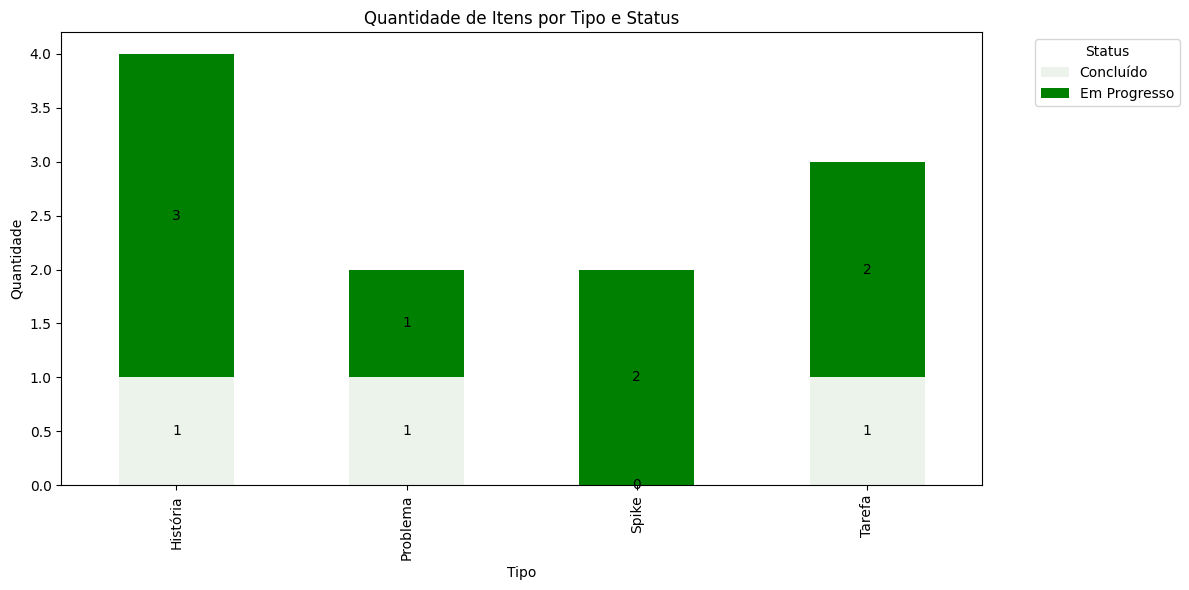

In [188]:
items_simplified = filter_items(df).copy()
# Apply the status mapping
items_simplified['status'] = items_simplified['status'].apply(simplify_status)

# Create pivot table with simplified status, ensure counts are integers
pivot_simplified = pd.crosstab(items_simplified['tipo'], items_simplified['status']).astype(int)

# Create stacked bar chart with adjusted parameters
colors = sns.light_palette("green", n_colors=2)
ax = pivot_simplified.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.title('Quantidade de Itens por Tipo e Status')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## Subtasks

In [189]:
# Get subtasks using filter_subitems
subtasks = filter_subitems(df)
subtask_count = subtasks['status'].value_counts()
total_subtasks = len(subtasks)

# Display the counts
print(f"Total de sub-tasks: {total_subtasks}")
print("\nQuantidade de sub-tasks por status no escopo da sprint:")
print(subtask_count)

Total de sub-tasks: 46

Quantidade de sub-tasks por status no escopo da sprint:
status
Concluída       36
Backlog          7
Em Andamento     3
Name: count, dtype: int64


In [197]:
# Obter as datas de início e fim da sprint ativa
sprint_start = sprint_df.loc[sprint_ativa, 'start']
sprint_end = sprint_df.loc[sprint_ativa, 'end']

# Filtrar sub-tasks criadas dentro do período da sprint ativa usando a função filter_subitems
subtasks_created = filter_subitems(df_geral[
    (df_geral['data_criacao'] >= sprint_start) &
    (df_geral['data_criacao'] <= sprint_end)
])

# Filtrar sub-tasks finalizadas dentro do período da sprint ativa
subtasks_completed = filter_subitems(df_geral[
    (df_geral['data_resolucao'] >= sprint_start) &
    (df_geral['data_resolucao'] <= sprint_end)
])

# Contabilizar o número de sub-tasks criadas e finalizadas
num_subtasks_created = len(subtasks_created)
num_subtasks_completed = len(subtasks_completed)

print(f"Sub-tasks criadas na {sprint_ativa}: {num_subtasks_created}")
print(f"Sub-tasks finalizadas na {sprint_ativa}: {num_subtasks_completed}")

Sub-tasks criadas na Izy - Cycle 24.1 Sprint 3: 13
Sub-tasks finalizadas na Izy - Cycle 24.1 Sprint 3: 22


<Figure size 1200x600 with 0 Axes>

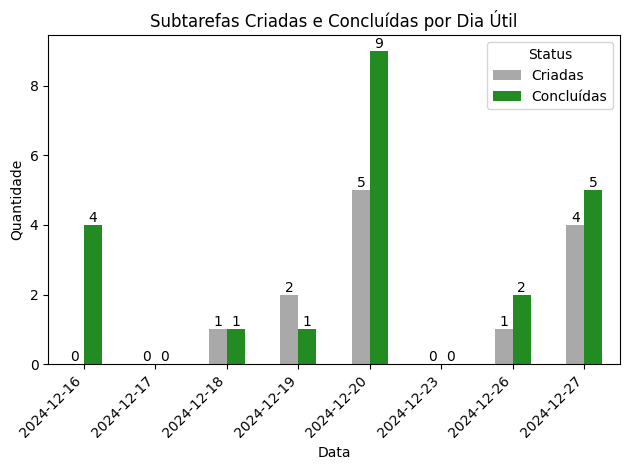

In [201]:
# Create a date range for working days (Monday to Friday)
date_range = pd.date_range(start=sprint_start, end=sprint_end, freq='B').strftime('%Y-%m-%d')

# Remove feriados do date range
holidays = pd.to_datetime(feriados_df[0])
date_range = date_range.difference(holidays)

# Initialize dictionaries to store counts per day
created_per_day = {date: 0 for date in date_range}
completed_per_day = {date: 0 for date in date_range}

# Count subtasks created and completed per day
for date in date_range:
    created_per_day[date] = len(subtasks_created[subtasks_created['data_criacao'] == pd.to_datetime(date).date()])
    completed_per_day[date] = len(subtasks_completed[subtasks_completed['data_resolucao'] == pd.to_datetime(date).date()])

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Criadas': created_per_day.values(),
    'Concluídas': completed_per_day.values()
}, index=date_range)

# Create the plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', color=['#A9A9A9', '#228B22'])  

# Customize the plot
plt.title('Subtarefas Criadas e Concluídas por Dia Útil')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

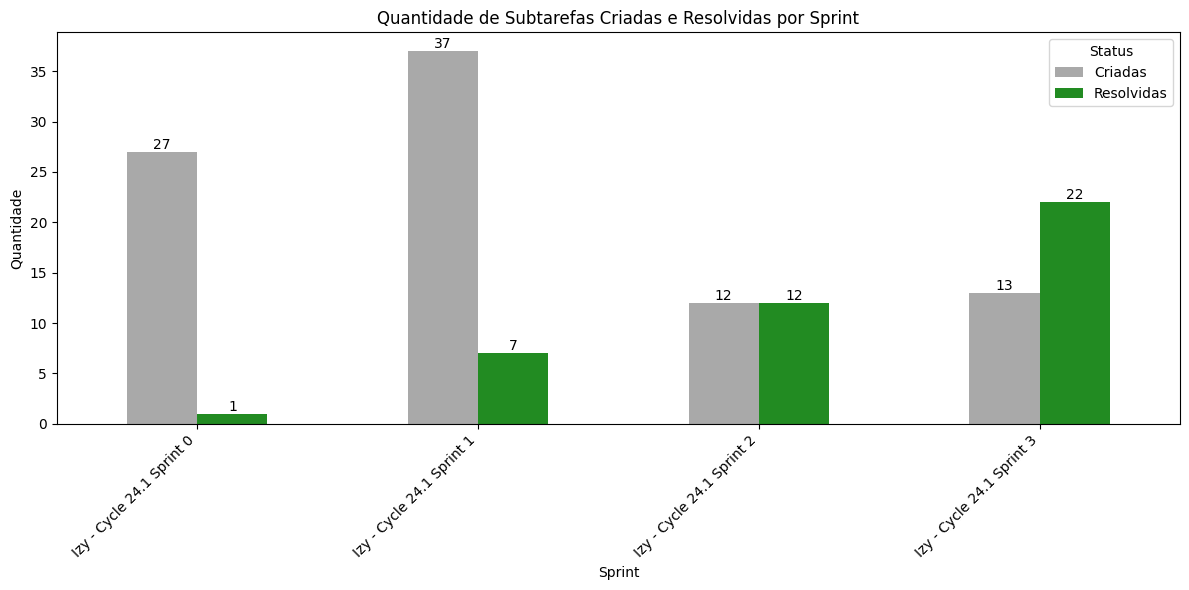

In [205]:
# Filtrar subtarefas criadas e resolvidas por sprint
subtasks_created_by_sprint = pd.Series(dtype=int)
subtasks_resolved_by_sprint = pd.Series(dtype=int)

for sprint, dates in sprint_df.iterrows():
    start_date = dates['start']
    end_date = dates['end']
    
    created_count = filter_subitems(df_geral[
        (df_geral['data_criacao'] >= start_date) &
        (df_geral['data_criacao'] <= end_date)
    ]).shape[0]
    
    resolved_count = filter_subitems(df_geral[
        (df_geral['data_resolucao'] >= start_date) &
        (df_geral['data_resolucao'] <= end_date)
    ]).shape[0]
    
    subtasks_created_by_sprint[sprint] = created_count
    subtasks_resolved_by_sprint[sprint] = resolved_count

# Criar um DataFrame com as contagens
subtasks_by_sprint = pd.DataFrame({
    'Criadas': subtasks_created_by_sprint,
    'Resolvidas': subtasks_resolved_by_sprint
}).fillna(0).astype(int)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
ax = subtasks_by_sprint.plot(kind='bar', figsize=(12, 6), color=['#A9A9A9', '#228B22'])

# Personalizar o gráfico
plt.title('Quantidade de Subtarefas Criadas e Resolvidas por Sprint')
plt.xlabel('Sprint')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status')

# Adicionar rótulos de valor nas barras
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

# Velocidade da Sprint

<Figure size 1200x600 with 0 Axes>

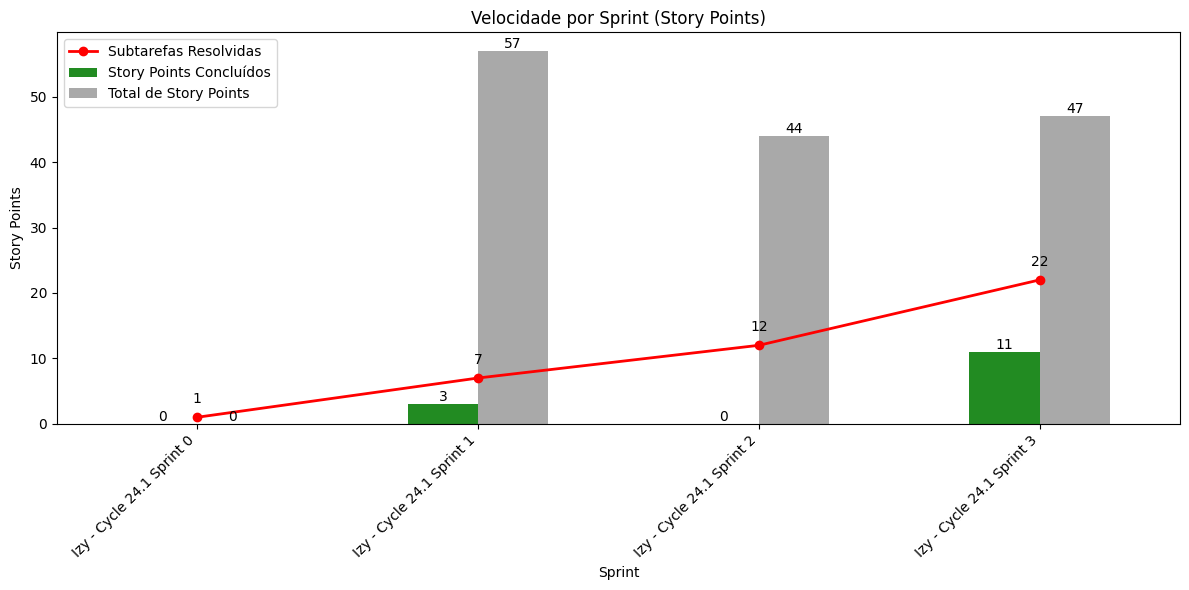

In [214]:
# Filtrar itens finalizados por sprint e somar os story points
velocity_by_sprint = pd.Series(dtype=float)
total_points_by_sprint = pd.Series(dtype=float)

for sprint, dates in sprint_df.iterrows():
    start_date = dates['start']
    end_date = dates['end']
    
    # Filtrar itens finalizados dentro do período da sprint
    completed_items = df_geral[
        (df_geral['data_resolucao'] >= start_date) &
        (df_geral['data_resolucao'] <= end_date) &
        (df_geral['status'] == 'Concluída')
    ]
    
    # Somar os story points dos itens finalizados
    total_story_points = completed_items['story_points'].sum()
    velocity_by_sprint[sprint] = total_story_points
    
    # Filtrar itens vinculados à sprint
    sprint_items = df_geral[
        (df_geral['sprint_1'] == sprint) |
        (df_geral['sprint_2'] == sprint) |
        (df_geral['sprint_3'] == sprint) |
        (df_geral['sprint_4'] == sprint)
    ]
    
    # Somar os story points dos itens vinculados à sprint
    total_points = sprint_items['story_points'].sum()
    total_points_by_sprint[sprint] = total_points

# Criar um DataFrame com as contagens
velocity_df = pd.DataFrame({
    'Story Points Concluídos': velocity_by_sprint,
    'Total de Story Points': total_points_by_sprint
}).fillna(0).astype(float)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
ax = velocity_df.plot(kind='bar', figsize=(12, 6), color=['#228B22', '#A9A9A9'])

# Adicionar linha vermelha representando subtarefas resolvidas por sprint
ax.plot(subtasks_resolved_by_sprint.index, subtasks_resolved_by_sprint.values, color='red', marker='o', linestyle='-', linewidth=2, label='Subtarefas Resolvidas')

# Adicionar rótulos de valor na linha
for i, txt in enumerate(subtasks_resolved_by_sprint.values):
    ax.annotate(txt, (subtasks_resolved_by_sprint.index[i], subtasks_resolved_by_sprint.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Personalizar o gráfico
plt.title('Velocidade por Sprint (Story Points)')
ax.set_xlabel('Sprint')
ax.set_ylabel('Story Points')
ax.set_xticklabels(velocity_df.index, rotation=45, ha='right')

# Adicionar rótulos de valor nas barras
for container in ax.containers:
    ax.bar_label(container)

# Adicionar legenda
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()
